In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
df = pd.read_csv("exoplanet_data.csv")
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all') #No null columns
# Drop the null rows
df = df.dropna() #No missing values
df.head()


koi_disposition  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  \
0       CONFIRMED              0              0              0              0   
1  FALSE POSITIVE              0              1              0              0   
2  FALSE POSITIVE              0              1              0              0   
3       CONFIRMED              0              0              0              0   
4       CONFIRMED              0              0              0              0   

   koi_period  koi_period_err1  koi_period_err2  koi_time0bk  \
0   54.418383     2.479000e-04    -2.479000e-04   162.513840   
1   19.899140     1.490000e-05    -1.490000e-05   175.850252   
2    1.736952     2.630000e-07    -2.630000e-07   170.307565   
3    2.525592     3.760000e-06    -3.760000e-06   171.595550   
4    4.134435     1.050000e-05    -1.050000e-05   172.979370   

   koi_time0bk_err1  ...  koi_steff_err2  koi_slogg  koi_slogg_err1  \
0          0.003520  ...             -81      4.467           0.064   
1          0.000581  ...            -176      4.544           0.044   
2          0.000115  ...            -174      4.564           0.053   
3          0.001130  ...            -211      4.438           0.070   
4          0.001900  ...            -232      4.486           0.054   

   koi_slogg_err2  koi_srad  koi_srad_err1  koi_srad_err2         ra  \
0          -0.096     0.927          0.105         -0.061  291.93423   
1          -0.176     0.868          0.233         -0.078  297.00482   
2          -0.168     0.791          0.201         -0.067  285.53461   
3          -0.210     1.046          0.334         -0.133  288.75488   
4          -0.229     0.972          0.315         -0.105  296.28613   

         dec  koi_kepmag  
0  48.141651      15.347  
1  48.134129      15.436  
2  48.285210      15.597  
3  48.226200      15.509  
4  48.224670      15.714  

[5 rows x 41 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6991 entries, 0 to 6990
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   koi_disposition    6991 non-null   object 
 1   koi_fpflag_nt      6991 non-null   int64  
 2   koi_fpflag_ss      6991 non-null   int64  
 3   koi_fpflag_co      6991 non-null   int64  
 4   koi_fpflag_ec      6991 non-null   int64  
 5   koi_period         6991 non-null   float64
 6   koi_period_err1    6991 non-null   float64
 7   koi_period_err2    6991 non-null   float64
 8   koi_time0bk        6991 non-null   float64
 9   koi_time0bk_err1   6991 non-null   float64
 10  koi_time0bk_err2   6991 non-null   float64
 11  koi_impact         6991 non-null   float64
 12  koi_impact_err1    6991 non-null   float64
 13  koi_impact_err2    6991 non-null   float64
 14  koi_duration       6991 non-null   float64
 15  koi_duration_err1  6991 non-null   float64
 16  koi_duration_err2  6991 

In [4]:
from sklearn.model_selection import train_test_split
X = df[df.columns.difference(['koi_disposition'])]
Y = df['koi_disposition']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

## Feature Selection

RFE wrapper with Random Forest Estimator for feature selection.
repeated stratified k-fold cross-validation, with 3 repeats and 5 folds.


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

num_features = [1]+list(range(5,45,5))
scores = []
for num_feature in num_features:
    # create pipeline
    scaler = MinMaxScaler()
    rfe = RFE(estimator=RandomForestClassifier(n_estimators=100), n_features_to_select=num_feature, verbose=5)
    model = SVC(kernel='rbf', C=100)
    pipeline = Pipeline(steps=[('scale', scaler), ('feature_selection',rfe),('model',model)])
    # evaluate model
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
    n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    # Append the scores for the "no" of features
    scores.append(n_scores)

In [6]:
# plot model performance for comparison
plt.boxplot(scores, labels=num_features, showmeans=True)
plt.show()

#### 30 features looks like the right options as it is stable.
#### Also, the accuracy is similar to that of all features.

In [7]:
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100), n_features_to_select=30, verbose=5)
rfe.fit(X_train, y_train)

Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.


RFE(estimator=RandomForestClassifier(), n_features_to_select=30, verbose=5)

In [8]:
X_train.columns[rfe.support_]

Index(['koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_duration',
       'koi_duration_err1', 'koi_duration_err2', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_impact',
       'koi_impact_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_model_snr', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_srad_err1',
       'koi_steff_err1', 'koi_steff_err2', 'koi_teq', 'koi_time0bk',
       'koi_time0bk_err1', 'koi_time0bk_err2', 'ra'],
      dtype='object')

In [9]:
X_test.columns[rfe.support_]

Index(['koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_duration',
       'koi_duration_err1', 'koi_duration_err2', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_impact',
       'koi_impact_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_model_snr', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_srad_err1',
       'koi_steff_err1', 'koi_steff_err2', 'koi_teq', 'koi_time0bk',
       'koi_time0bk_err1', 'koi_time0bk_err2', 'ra'],
      dtype='object')

In [10]:
#X_train.columns[rfe.support_]
X_train = X_train[X_train.columns[rfe.support_]]
X_test = X_test[X_test.columns[rfe.support_]]

## SVM without tuning

In [11]:
# create pipeline
scaler = MinMaxScaler()
model = SVC(class_weight = 'balanced')
pipeline = Pipeline(steps=[('scale', scaler), ('model',model)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scale', MinMaxScaler()),
                ('model', SVC(class_weight='balanced'))])

In [12]:
print(f"Train accuracy : {pipeline.score(X_train, y_train)}")
print(f"Test accuracy : {pipeline.score(X_test, y_test)}")

Train accuracy : 0.835781041388518
Test accuracy : 0.834096109839817


## GridSearch CV to tune SVM

In [40]:
from sklearn.model_selection import GridSearchCV
param_grid = {'model__C': [1, 5, 10, 100],
              'model__gamma': ['scale', 0.1],
              'model__kernel': ['poly','linear', 'rbf']
               }

# create pipeline
scaler = MinMaxScaler()
model = SVC(class_weight = 'balanced')
pipeline = Pipeline(steps=[('scale', scaler), ('model',model)])

gcv = GridSearchCV(
        pipeline, 
        param_grid,
        cv=5,
        scoring = 'accuracy',
        verbose=5
    )

gcv.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END model__C=1, model__gamma=scale, model__kernel=poly;, score=0.876 total time=   0.2s
[CV 2/5] END model__C=1, model__gamma=scale, model__kernel=poly;, score=0.837 total time=   0.2s
[CV 3/5] END model__C=1, model__gamma=scale, model__kernel=poly;, score=0.863 total time=   0.2s
[CV 4/5] END model__C=1, model__gamma=scale, model__kernel=poly;, score=0.839 total time=   0.2s
[CV 5/5] END model__C=1, model__gamma=scale, model__kernel=poly;, score=0.844 total time=   0.2s
[CV 1/5] END model__C=1, model__gamma=scale, model__kernel=linear;, score=0.871 total time=   0.2s
[CV 2/5] END model__C=1, model__gamma=scale, model__kernel=linear;, score=0.827 total time=   0.2s
[CV 3/5] END model__C=1, model__gamma=scale, model__kernel=linear;, score=0.859 total time=   0.2s
[CV 4/5] END model__C=1, model__gamma=scale, model__kernel=linear;, score=0.834 total time=   0.2s
[CV 5/5] END model__C=1, model__gamma=scale, model__kerne

[CV 1/5] END model__C=10, model__gamma=0.1, model__kernel=rbf;, score=0.883 total time=   0.4s
[CV 2/5] END model__C=10, model__gamma=0.1, model__kernel=rbf;, score=0.839 total time=   0.4s
[CV 3/5] END model__C=10, model__gamma=0.1, model__kernel=rbf;, score=0.866 total time=   0.4s
[CV 4/5] END model__C=10, model__gamma=0.1, model__kernel=rbf;, score=0.845 total time=   0.4s
[CV 5/5] END model__C=10, model__gamma=0.1, model__kernel=rbf;, score=0.853 total time=   0.4s
[CV 1/5] END model__C=100, model__gamma=scale, model__kernel=poly;, score=0.902 total time=   0.2s
[CV 2/5] END model__C=100, model__gamma=scale, model__kernel=poly;, score=0.876 total time=   0.2s
[CV 3/5] END model__C=100, model__gamma=scale, model__kernel=poly;, score=0.888 total time=   0.2s
[CV 4/5] END model__C=100, model__gamma=scale, model__kernel=poly;, score=0.872 total time=   0.2s
[CV 5/5] END model__C=100, model__gamma=scale, model__kernel=poly;, score=0.883 total time=   0.2s
[CV 1/5] END model__C=100, mod

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('model',
                                        SVC(class_weight='balanced'))]),
             param_grid={'model__C': [1, 5, 10, 100],
                         'model__gamma': ['scale', 0.1],
                         'model__kernel': ['poly', 'linear', 'rbf']},
             scoring='accuracy', verbose=5)

#### Best parameters

In [42]:
gcv.best_params_


{'model__C': 100, 'model__gamma': 'scale', 'model__kernel': 'linear'}

#### Best Score

In [44]:
gcv.best_score_

0.884223615366143

### Model Evaluation on test data

In [50]:
from sklearn.metrics import plot_confusion_matrix
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

model = SVC(class_weight = 'balanced', C = 100, kernel = 'linear') #gamma is not applicable to linear kernel
model.fit(X_train_scaled, y_train)

#On test
X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)



Accuracy: 0.881


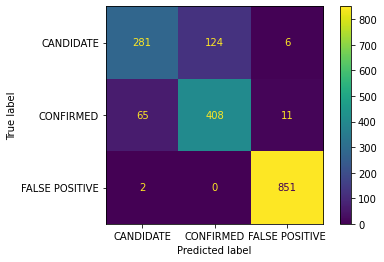

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
DTcm_tr_tune = confusion_matrix(y_test, y_pred, labels=model.classes_) # imported sklearn function
DTdisp_tr_tune = ConfusionMatrixDisplay(confusion_matrix=DTcm_tr_tune, display_labels=model.classes_) # imported sklearn function
DTdisp_tr_tune.plot()

print('Accuracy: %.3f' % model.score(X_test_scaled, y_test))

In [53]:
import joblib
filename = 'M2_Rajesh_SVM.sav'
joblib.dump(model, filename)  

['M2_Rajesh_SVM.sav']